In [1]:
import markcorr
import os
import shutil
import pandas as pd
import numpy as np
import altair as alt
from window import *
from pointPattern import *
import math
import pandas as pd
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from breakpts import *
from sm_density import *
from closepairs import *
from window import *
from unnormdensity import *
from multiprocessing import Pool
from matplotlib.lines import Line2D
import scipy.stats as ss
import scikit_posthocs as sp
import statsmodels.stats.multitest as multi
import altair_saver
from xgboost import XGBClassifier

ModuleNotFoundError: No module named 'scikit_posthocs'

In [ ]:
import betacells

In [2]:
normal = pd.read_csv("../data/output/Normal.csv")
aml = pd.read_csv("../data/output/AML.csv")
imageSize_x = 1056
imageSize_y = 642
W = window((0, imageSize_x), (0, imageSize_y))
antibody_cell = {"Intensity_Adipocytes": "Adipocytes", "Intensity_CD163" : "Macrophages", "Intensity_CD20" : "B_cells", "Intensity_CD3" : "T_cells", 
                 "Intensity_CD31" : "Megakaryocytes", "Intensity_CD34" : "HSC", "Intensity_CD68" : "Monocytes", "Intensity_Erythroids" : "Erythroids",
                 "Intensity_Ki67" : "Ki67", "Intensity_MPO" : "Myeloids", "Intensity_NGFR" : "MSC"}

FileNotFoundError: [Errno 2] No such file or directory: '../data/output/Normal.csv'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

auc_normal_r = pd.DataFrame()
patient_label = []
for i in range(15):  
    isoResult = pd.read_csv("./result2/Normal/image_%d/iso.csv"%i).drop(["Unnamed: 0"], axis=1)
    isoMin = isoResult.where(isoResult > 0).min().min()
    logRes = np.log2(isoResult.where(isoResult > 0, isoMin))
    patient_num = i//3+1
    patient_label.append(str(patient_num))
    roi_num = i%3+1
    index = "Normal_patient_"+str(patient_num)+"_ROI_"+str(roi_num)
    auc_normal_r[index] = logRes.sum(axis = 0)
auc_normal_r.loc['patient_label'] = patient_label
auc_normal_r = auc_normal_r[auc_normal_r != 0]
auc_normal_r = auc_normal_r.transpose()
auc_normal_r["label"] = "0"

auc_aml_r = pd.DataFrame()
patient_label = []
for i in range(36):  
    isoResult = pd.read_csv("./result2/AML/image_%d/iso.csv"%i).drop(["Unnamed: 0"], axis=1)
    isoMin = isoResult.where(isoResult > 0).min().min()
    logRes = np.log2(isoResult.where(isoResult > 0, isoMin))
    patient_num = i//3
    roi_num = i%3+1
    patient_label.append(str(patient_num+6))
    index = "AML_patient_"+str(patient_num)+"_ROI_"+str(roi_num)
    auc_aml_r[index] = logRes.sum()
auc_aml_r.loc['patient_label'] = patient_label
auc_aml_r = auc_aml_r[auc_aml_r != 0]
auc_aml_r = auc_aml_r.transpose()
auc_aml_r["label"] = "1"


auc_r = pd.concat([auc_normal_r, auc_aml_r], axis=0)
field = auc_r.columns
cell_to_marker = {  "HSC" : "CD34", "MSC" : "NGFR", 
                  "Macrophages" : "CD163", "Megakaryocytes" : "CD31", "Monocytes" : "CD68", "Myeloids" : "MPO", "T_cells" : "CD3"}
new_field = []
for feature in field:
    # print(feature)
    feature = feature.replace('Intensity_','')
    feature = feature.replace('CD20','B_cells')
    feature = feature.replace('CD34','HSC')
    feature = feature.replace('NGFR','MSC')
    feature = feature.replace('CD163','Macrophages')
    feature = feature.replace('CD31','Megakaryocytes')
    feature = feature.replace('CD68','Monocytes')
    feature = feature.replace('MPO','Myeloids')
    feature = feature.replace('CD3','T_cells')
    new_field.append(feature)
    
new_field
auc_r.columns = new_field

               0             1             2
0   -5702.813870  -2984.006362  -2774.004975
1   -4848.347077   2350.614691  -3209.455973
2   -6739.777365  -3660.960039   -569.826002
3   -7727.273046  -2443.555993  -2497.895511
4    9388.904908  11116.460708  -4280.020120
5   -3057.002879   1291.055154  -4315.559256
6   -1645.668832   3465.125642  -4066.702796
7   -1134.549545   6787.411722  -4742.714338
8    5324.470331  10271.557692  -4654.959117
9   -6491.695816    472.904478  -2733.263456
10   2839.402431   8339.665502  -8174.884942
11   6726.678828  -1032.123956  -4260.216928
12 -10833.017747   1250.584692  -2743.310372
13  -9908.712448    -42.838375  -2871.998111
14 -11079.650266   1022.244259  -3348.383452
15   1789.917329  32244.971274  27095.540047
16  11137.550633  37676.913438  14690.306345
17   1699.920941  -5739.397732  -2405.632708
18  19247.831165  16224.474980  -8171.707793
19  44749.651438  19418.877837 -14115.787378
20  51555.917797   8663.563399 -13440.085249
21  10408.

<Figure size 640x480 with 0 Axes>

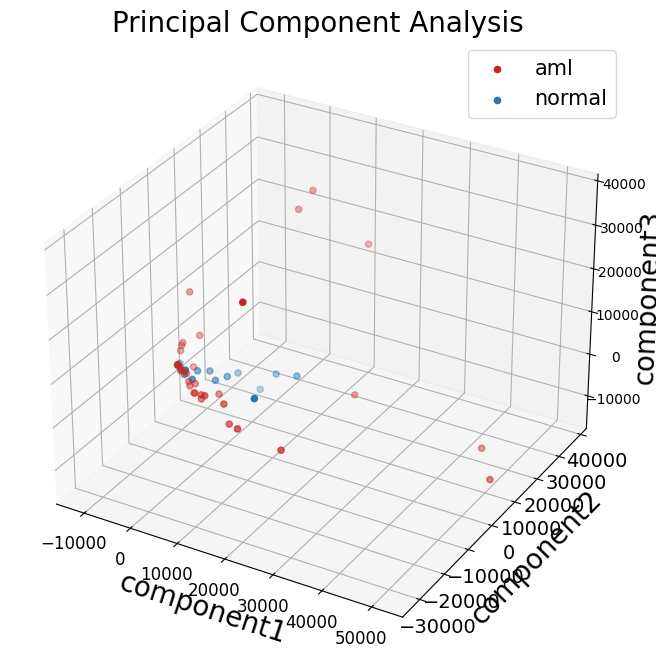

In [3]:
from mpl_toolkits import mplot3d
def plot_aml_pca(auc_r):
    # plt.scatter(auc_r[component1], auc_r[component2])
    auc_r=auc_r.reset_index()
    auc_r=auc_r.fillna(0)
    auc_r = auc_r.drop('index', axis=1)
    # print(auc_r)
    pca_r = PCA(n_components=3)
    # auc_r_select = auc_r
    pca_r_fit = pca_r.fit_transform(auc_r)
    principal_Df = pd.DataFrame(data = pca_r_fit)
    print(principal_Df)
    plt.figure()
    plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=14)
    ax.set_xlabel("component1",fontsize=20)
    ax.set_ylabel("component2",fontsize=20)
    ax.set_zlabel("component3",fontsize=20)
    plt.title("Principal Component Analysis",fontsize=20)
    targets = ["1","0"]
    colors = ['#c82423', '#2878b5']
    # print(auc_r["label"])
    # auc_r=auc_r.reset_index()
    print('Explained variation; per principal component: {}'.format(pca_r.explained_variance_ratio_))
    for target, color in zip(targets,colors):
        indicesToKeep = np.where(auc_r["label"] == target)[0]
        ax.scatter(principal_Df.iloc[indicesToKeep, 0]
                , principal_Df.iloc[indicesToKeep, 1], principal_Df.iloc[indicesToKeep, 2], c = color)
    plt.legend(["aml","normal"],prop={'size': 15})
    return principal_Df

principal_Df=plot_aml_pca(auc_r)

Explained variation; per principal component: [0.3243714  0.29082648]


<Figure size 640x480 with 0 Axes>

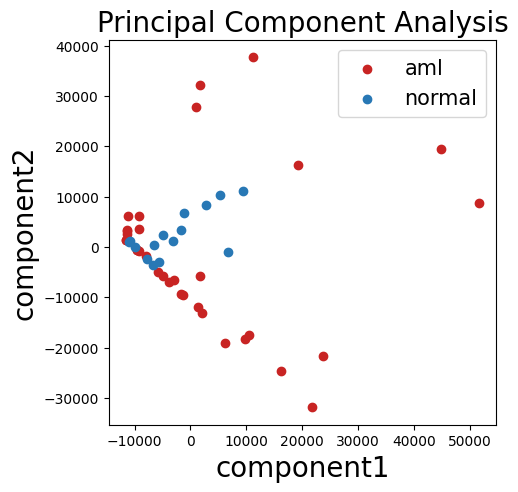

In [4]:
def plot_aml_pca(auc_r):
    # plt.scatter(auc_r[component1], auc_r[component2])
    auc_r=auc_r.reset_index()
    auc_r=auc_r.fillna(0)
    auc_r = auc_r.drop('index', axis=1)
    # print(auc_r)
    pca_r = PCA(n_components=2)
    # auc_r_select = auc_r
    pca_r_fit = pca_r.fit_transform(auc_r)
    principal_Df = pd.DataFrame(data = pca_r_fit)
    plt.figure()
    plt.figure(figsize=(5,5))
    ax = plt.axes(projection=None)
    # plt.xticks(fontsize=12)
    # plt.yticks(fontsize=14)
    ax.set_xlabel("component1",fontsize=20)
    ax.set_ylabel("component2",fontsize=20)
    plt.title("Principal Component Analysis",fontsize=20)
    targets = ["1","0"]
    colors = ['#c82423', '#2878b5']
    # print(auc_r["label"])
    # auc_r=auc_r.reset_index()
    print('Explained variation; per principal component: {}'.format(pca_r.explained_variance_ratio_))
    for target, color in zip(targets,colors):
        indicesToKeep = np.where(auc_r["label"] == target)[0]
        ax.scatter(principal_Df.iloc[indicesToKeep, 0]
                , principal_Df.iloc[indicesToKeep, 1], c = color)
    plt.legend(["aml","normal"],prop={'size': 15})
    return principal_Df

principal_Df=plot_aml_pca(auc_r)

Explained variation; per principal component: [0.3243714  0.29082648 0.14116677]
Explained variation; per principal component: [0.3243714  0.29082648 0.14116677]


<Figure size 640x480 with 0 Axes>

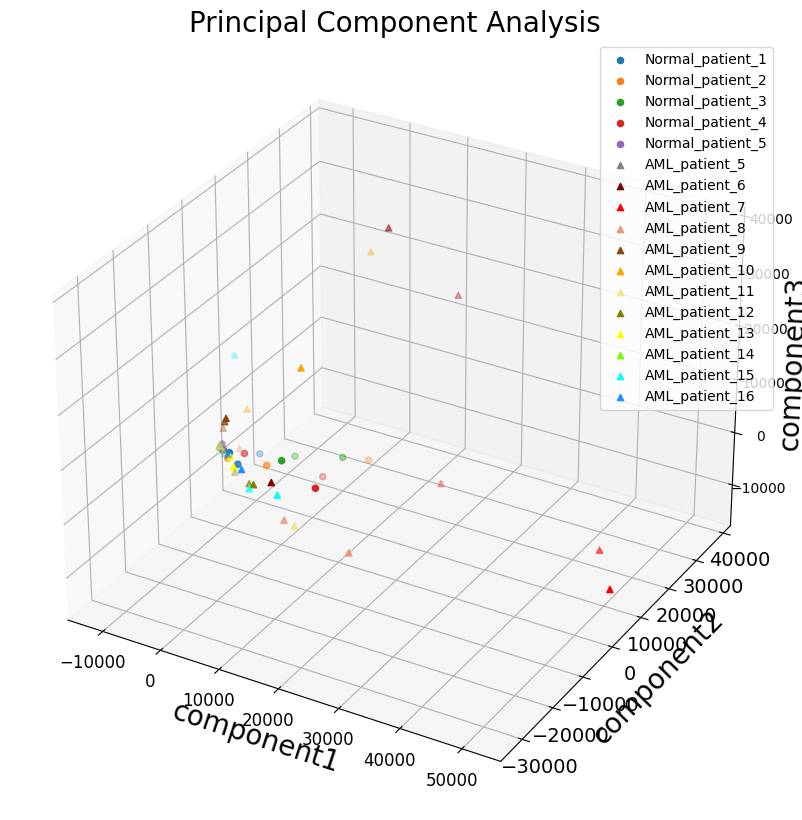

In [5]:
from mpl_toolkits import mplot3d
import random
def random_color_generator(fraction):
    # r = (255-150) * fraction + 150
    # g = (155-120) * fraction  + 120
    # b = (255-130)* fraction + 130
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return (r/255, g/255, b/255)

def plot_aml_pca(auc_r):
    # plt.scatter(auc_r[component1], auc_r[component2])
    auc_r=auc_r.reset_index()
    auc_r=auc_r.fillna(0)
    auc_r = auc_r.drop('index', axis=1)
    # print(auc_r)
    pca_r = PCA(n_components=3)
    # auc_r_select = auc_r
    pca_r_fit = pca_r.fit_transform(auc_r)
    principal_Df = pd.DataFrame(data = pca_r_fit)
    # print(principal_Df)
    plt.figure()
    plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=14)
    ax.set_xlabel("component1",fontsize=20)
    ax.set_ylabel("component2",fontsize=20)
    ax.set_zlabel("component3",fontsize=20)
    plt.title("Principal Component Analysis",fontsize=20)
    targets = []
    targets_name = []
    colors = []


    # the starting color
    initial_color = (0.60156, 0, 0.99218)  # (154, 0, 254)

    # the final, target color
    target_color = (0.86328, 0.47656, 0.31250)  # (221, 122, 80)
    deltas=[(target_color[i] - initial_color[i])/17 for i in range(3)]
    for j in range(0, 5):
        interpolated_color=tuple([initial_color[i] + (deltas[i] * j) for i in range(3)])
        colors.append(interpolated_color)



    for i in range(0,5):
        targets.append(str(i))
        if i<5:
            targets_name.append("Normal_patient_"+str(i+1))
        else:
            targets_name.append("AML_patient_"+str(i+6))
    print('Explained variation; per principal component: {}'.format(pca_r.explained_variance_ratio_))
    for target, color in zip(targets_name,colors):
        indicesToKeep = np.where(auc_r["patient_label"] == target.strip().split('_')[2])[0]
        ax.scatter(principal_Df.iloc[indicesToKeep, 0]
                , principal_Df.iloc[indicesToKeep, 1], principal_Df.iloc[indicesToKeep, 2])
    plt.legend(targets_name,prop={'size': 10})



    for j in range(5,17):
        interpolated_color=tuple([initial_color[i] + (deltas[i] * j) for i in range(3)])
        colors.append(interpolated_color)


    for i in range(5,17):
        targets.append(str(i))
        targets_name.append("AML_patient_"+str(i))
    print('Explained variation; per principal component: {}'.format(pca_r.explained_variance_ratio_))    
    colors = ["blueviolet","fuchsia","lightcoral","sienna","peru","gray","maroon","red","darksalmon","saddlebrown","orange","khaki","olive",
              "yellow","lawngreen","cyan","dodgerblue"]
    i=0
    for target, color in zip(targets_name,colors):
        if i<5:
            i=i+1
            continue
        indicesToKeep = np.where(auc_r["patient_label"] == target.strip().split('_')[2])[0]
        ax.scatter(principal_Df.iloc[indicesToKeep, 0], principal_Df.iloc[indicesToKeep, 1], principal_Df.iloc[indicesToKeep, 2], marker = "^",c=color)
    plt.legend(targets_name,prop={'size': 10})
    return principal_Df

principal_Df=plot_aml_pca(auc_r)

Explained variation; per principal component: [0.3243714  0.29082648]
Explained variation; per principal component: [0.3243714  0.29082648]


<Figure size 640x480 with 0 Axes>

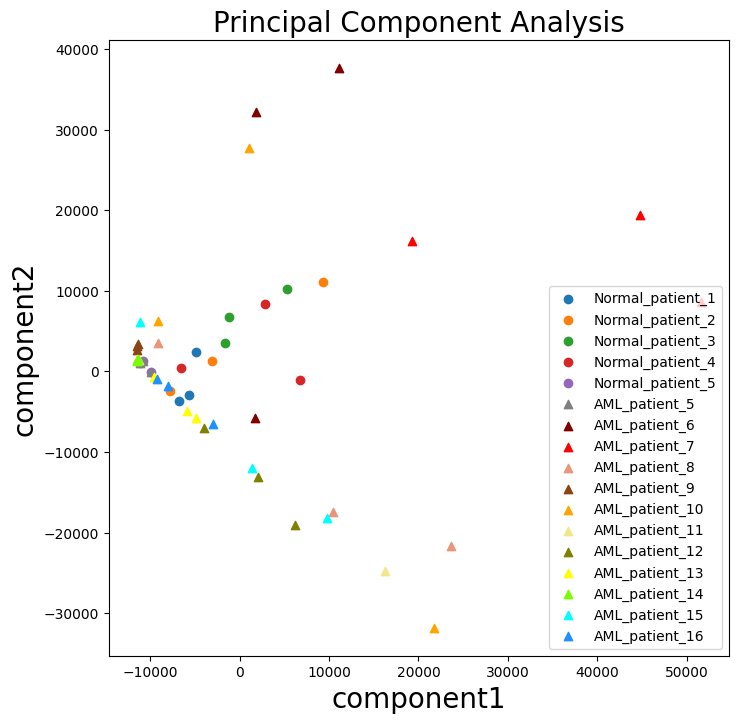

In [6]:
def plot_pca_2d(auc_r):
    # plt.scatter(auc_r[component1], auc_r[component2])
    auc_r=auc_r.reset_index()
    auc_r=auc_r.fillna(0)
    auc_r = auc_r.drop('index', axis=1)
    # print(auc_r)
    pca_r = PCA(n_components=2)
    # auc_r_select = auc_r
    pca_r_fit = pca_r.fit_transform(auc_r)
    principal_Df = pd.DataFrame(data = pca_r_fit)
    # print(principal_Df)
    plt.figure()
    plt.figure(figsize=(8,8))
    # plt.xticks(fontsize=12)
    # plt.yticks(fontsize=14)
    ax = plt.axes(projection=None)
    ax.set_xlabel("component1",fontsize=20)
    ax.set_ylabel("component2",fontsize=20)
    plt.title("Principal Component Analysis",fontsize=20)
    targets = []
    targets_name = []
    colors = []


    # the starting color
    initial_color = (0.60156, 0, 0.99218)  # (154, 0, 254)

    # the final, target color
    target_color = (0.86328, 0.47656, 0.31250)  # (221, 122, 80)
    deltas=[(target_color[i] - initial_color[i])/17 for i in range(3)]
    for j in range(0, 5):
        interpolated_color=tuple([initial_color[i] + (deltas[i] * j) for i in range(3)])
        colors.append(interpolated_color)



    for i in range(0,5):
        targets.append(str(i))
        targets_name.append("Normal_patient_"+str(i+1))
    print('Explained variation; per principal component: {}'.format(pca_r.explained_variance_ratio_))
    for target, color in zip(targets_name,colors):
        indicesToKeep = np.where(auc_r["patient_label"] == target.strip().split('_')[2])[0]
        ax.scatter(principal_Df.iloc[indicesToKeep, 0], principal_Df.iloc[indicesToKeep, 1])
    plt.legend(targets_name,prop={'size': 10})



    for j in range(5,17):
        interpolated_color=tuple([initial_color[i] + (deltas[i] * j) for i in range(3)])
        colors.append(interpolated_color)


    for i in range(5,17):
        targets.append(str(i))
        targets_name.append("AML_patient_"+str(i))
    print('Explained variation; per principal component: {}'.format(pca_r.explained_variance_ratio_))
    colors = ["blueviolet","fuchsia","lightcoral","sienna","peru","gray","maroon","red","darksalmon","saddlebrown","orange","khaki","olive",
              "yellow","lawngreen","cyan","dodgerblue"]
    i=0
    for target, color in zip(targets_name,colors):
        if i<5:
            i=i+1
            continue
        indicesToKeep = np.where(auc_r["patient_label"] == target.strip().split('_')[2])[0]
        ax.scatter(principal_Df.iloc[indicesToKeep, 0], principal_Df.iloc[indicesToKeep, 1], marker = "^", c=color)
    plt.legend(targets_name,prop={'size': 10})
    return principal_Df

principal_Df=plot_pca_2d(auc_r)

In [7]:
# import matplotlib as mpl
# mpl.rcParams['figure.facecolor'] = 'white'

principal_Df_normal = principal_Df[0:16]
principal_Df_aml = principal_Df[16:]
x_n = principal_Df_normal[0].tolist()
y_n = principal_Df_normal[1].tolist()
z_n = principal_Df_normal[2].tolist()
x_a = principal_Df_aml[0].tolist()
y_a = principal_Df_aml[1].tolist()
z_a = principal_Df_aml[2].tolist()
import math
from itertools import combinations
import numpy as np


def dist(p1, p2):
    [x1, y1, z1], [x2, y2, z2] = p1, p2
    p1 = np.array(p1)
    p2 = np.array(p2)
    squared_dist = np.sum((p1-p2)**2, axis=0)
    dist = np.sqrt(squared_dist)
    return dist


points_n = list(zip(x_n,y_n,z_n))
distances_n = [dist(p1, p2) for p1, p2 in combinations(points_n, 2)]
avg_distance_n = sum(distances_n) / len(distances_n)
std_dev_n = np.std(np.array(distances_n))
print(avg_distance_n)


points_a = list(zip(x_a,y_a,z_a))
distances_a = [dist(p1, p2) for p1, p2 in combinations(points_a, 2)]
avg_distance_a = sum(distances_a) / len(distances_a)
std_dev_a = np.std(np.array(distances_a))
print(avg_distance_a)
bars = [avg_distance_n,avg_distance_a]
x_pos = np.arange(len(bars))

# datasets = np.array([distances_n,distances_a])
# average = datasets.mean(axis=0)
# std_dev = datasets.std(axis=0)
print([std_dev_n,std_dev_a])
plt.bar(x_pos, bars, yerr=[std_dev_n,std_dev_a],color=['#c82423', '#2878b5'], width=0.2)
plt.xticks(x_pos, ("normal","aml"))
plt.show()

KeyError: 2

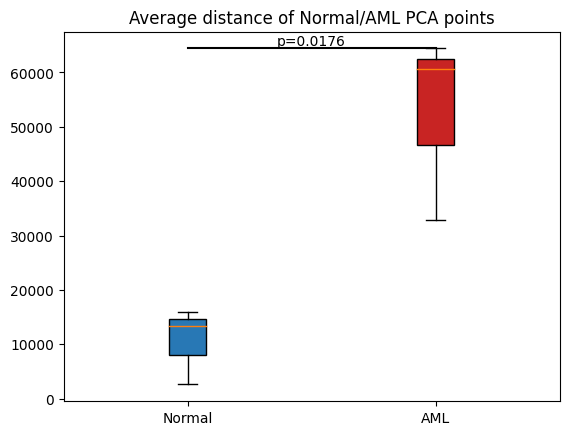

In [36]:
fig = plt.figure()
data = [distances_n,distances_a]
ax = fig.add_subplot()
bp = ax.boxplot([distances_n,distances_a], patch_artist = True)
ax.set_xticklabels(['Normal','AML'])
colors = ['#2878b5','#c82423']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

x1, x2 = 1,2
y, h, col = max(map(max, data)) + 2, 2, 'k'

plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text(1.5, y+h, "p=0.0176", ha='center', va='bottom')
plt.title("Average distance of Normal/AML PCA points")
plt.show()

In [ ]:
normal_average=[]
aml_average=[]
for i in range(0,5,1):
    x_n = principal_Df_normal[i:i+3][0].tolist()
    y_n = principal_Df_normal[i:i+3][1].tolist()
    z_n = principal_Df_normal[i:i+3][2].tolist()
    points_n = list(zip(x_n,y_n,z_n))
    distances_n = [dist(p1, p2) for p1, p2 in combinations(points_n, 2)]
    avg_distance_n = sum(distances_n) / len(distances_n)
    normal_average.append(avg_distance_n)
    # aml_average.append(0)
for i in range(0,12,1):
    x_a = principal_Df_aml[i:i+3][0].tolist()
    y_a = principal_Df_aml[i:i+3][1].tolist()
    z_a = principal_Df_aml[i:i+3][2].tolist()
    points_a = list(zip(x_a,y_a,z_a))
    distances_a = [dist(p1, p2) for p1, p2 in combinations(points_a, 2)]
    avg_distance_a = sum(distances_a) / len(distances_a)
    aml_average.append(avg_distance_a)
    # normal_average.append(0)
avg_distance_a = sum(aml_average) / len(aml_average)
avg_distance_n = sum(normal_average) / len(normal_average)
bars = [avg_distance_n,avg_distance_a]
x_pos = np.arange(len(bars))
ax = plt.axes()
ax.set_facecolor("white")
plt.bar(x_pos, bars,color=['#c82423', '#2878b5'], width=0.2)
plt.xticks(x_pos, ("normal","aml"))
plt.title("Average variation of each AML/Normal patient")
plt.show()
# values = np.array([aml_average,normal_average])
# values = values.T
# groups = ['aml','normal']
# fig, ax = plt.subplots()
# for i in range(values.shape[0]):
#   ax.bar(groups, values[i], bottom = np.sum(values[:i], axis = 0), width=0.2)
# plt.show()


In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
bp = ax.boxplot([normal_average,aml_average], patch_artist = True)
ax.set_xticklabels(['Normal','AML'])
colors = ['#c82423', '#2878b5']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

Text(0.5, 1.0, 'Average distance of each patient in Normal/AML')

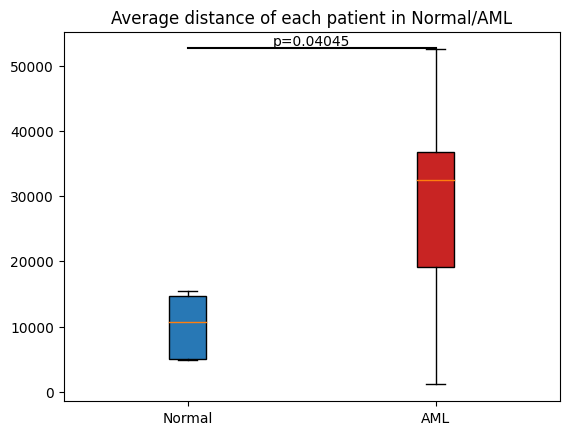

In [35]:
# ttest_ind(normal_average,aml_average)
data = [normal_average,aml_average]
fig = plt.figure()
ax = fig.add_subplot()
bp = ax.boxplot([normal_average,aml_average], patch_artist = True)
ax.set_xticklabels(['Normal','AML'])
colors = ['#2878b5','#c82423']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

x1, x2 = 1,2
y, h, col = max(map(max, data)) + 2, 2, 'k'

plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text(1.5, y+h, "p=0.04045", ha='center', va='bottom')
plt.title("Average distance of each patient in Normal/AML")

Ttest_indResult(statistic=-2.242725510414521, pvalue=0.040449048808395324)

In [ ]:
normal_average=[]
aml_average=[]
group=[]
count = 0
for i in range(0,5,1):
    x_n = principal_Df_normal[i:i+3][0].tolist()
    y_n = principal_Df_normal[i:i+3][1].tolist()
    z_n = principal_Df_normal[i:i+3][2].tolist()
    points_n = list(zip(x_n,y_n,z_n))
    distances_n = [dist(p1, p2) for p1, p2 in combinations(points_n, 2)]
    avg_distance_n = sum(distances_n) / len(distances_n)
    normal_average.append(avg_distance_n)
    aml_average.append(0)
    group.append(count)
    count+=1
for i in range(0,12,1):
    x_a = principal_Df_aml[i:i+3][0].tolist()
    y_a = principal_Df_aml[i:i+3][1].tolist()
    z_a = principal_Df_aml[i:i+3][2].tolist()
    points_a = list(zip(x_a,y_a,z_a))
    distances_a = [dist(p1, p2) for p1, p2 in combinations(points_a, 2)]
    avg_distance_a = sum(distances_a) / len(distances_a)
    aml_average.append(avg_distance_a)
    normal_average.append(0)
    group.append(count)
    count+=1
values = np.array([aml_average,normal_average])
plt.bar(group,list(values[0]),color='#2878b5')
plt.bar(group,list(values[1]),color='#c82423')
plt.title("Variation of each patient")
plt.show()

In [ ]:
import plotly.graph_objects as go
import plotly.figure_factory as ff

import numpy as np
from scipy.spatial.distance import pdist, squareform
import seaborn as sns


data_array=auc_r.T
data_array
data_array=data_array.fillna(0)
data_array = data_array.astype(np.float32)
# Default plot
g = sns.clustermap(data_array,z_score=1,cmap='RdBu')

# hemi_labels = data_array.loc['label']
# species_list = hemi_labels.unique()
# label_colours = dict(zip(species_list, sns.color_palette("colorblind", len(species_list))))
# row_colours = hemi_labels.map(label_colours)
# # hemi_lut = ['#c82423', '#2878b5']
# for (label, colour) in label_colours.items():
#     g.ax_col_dendrogram.bar(0, 0, color=colour, label="{}".format(label))

# l1 = g.ax_row_dendrogram.legend(title='Patient', loc="upper right", ncol=1, bbox_to_anchor=(1.2,0.55), bbox_transform=plt.gcf().transFigure)

# Show the graph
plt.show()


Int64Index([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
            1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            1, 1, 1, 1, 1, 1, 1],
           dtype='int64', name='label')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


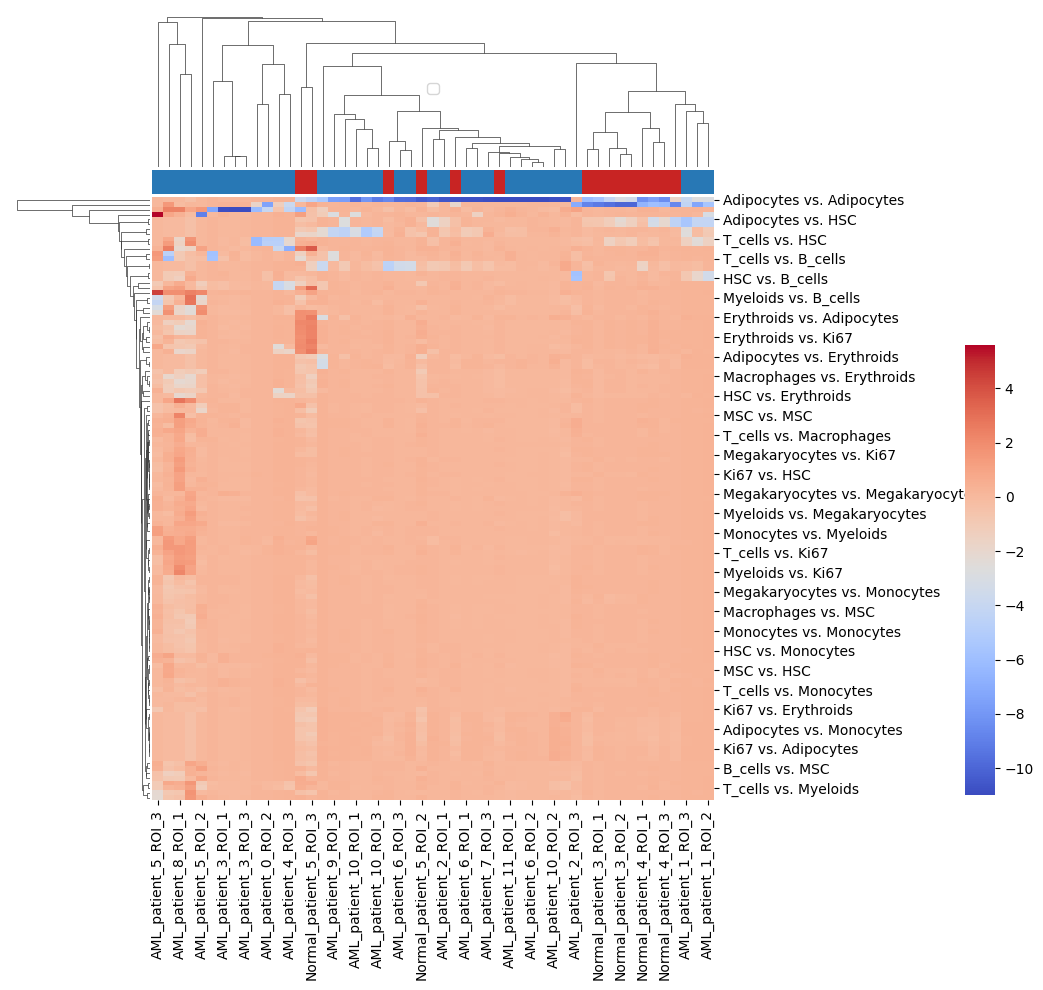

In [9]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import seaborn as sns


data_array=auc_r.T
data_array
data_array=data_array.fillna(0)
data_array = data_array.astype(np.float32)
# Default plot
# g = sns.clustermap(data_array,z_score=1,cmap='RdBu')

# print(data_array.index)
da = pd.MultiIndex.from_frame(data_array.T)
used_columns = (da.get_level_values('label')
                          .astype(int))

print(used_columns)
network_colors = []
for i in used_columns:
    if i==0:
        network_colors.append('#c82423')
    else:
        network_colors.append('#2878b5')
g = sns.clustermap(data_array,z_score=1,cmap='coolwarm',col_colors=network_colors)
g.ax_col_dendrogram.legend(loc="center", ncol=2)
# Adjust the postion of the main colorbar for the heatmap
g.cax.set_position([.97, .2, .03, .45])
plt.show()

In [18]:
from_cell_type = []
to_cell_type = []
from_cell_color = []
to_cell_color = []
cell_to_marker = {"Adipocytes", "B_cells", "HSC", "Erythroids", "Ki67", "MSC", 
                  "Macrophages", "Megakaryocytes", "Monocytes", "Myeloids", "T_cells"}
for i in data_array.index:
    if (' vs. ') not in i:
        continue
    from_cell_type.append(i.strip().split(' vs. ')[0])
    to_cell_type.append(i.strip().split(' vs. ')[1])
    if i.strip().split(' vs. ')[1] == "Adipocytes":
        to_cell_color.append('#1f77b4')
    elif i.strip().split(' vs. ')[1] == "B_cells":
        to_cell_color.append('#ff7f0e')
    elif i.strip().split(' vs. ')[1] == "HSC":
        to_cell_color.append('#2ca02c')
    elif i.strip().split(' vs. ')[1] == "Erythroids":
        to_cell_color.append('#d62728')
    elif i.strip().split(' vs. ')[1] == "Ki67":
        to_cell_color.append('#9467bd')
    elif i.strip().split(' vs. ')[1] == "MSC":
        to_cell_color.append('#8c564b')
    elif i.strip().split(' vs. ')[1] == "Macrophages":
        to_cell_color.append('#e377c2')
    elif i.strip().split(' vs. ')[1] == "Megakaryocytes":
        to_cell_color.append('#7f7f7f')
    elif i.strip().split(' vs. ')[1] == "Monocytes":
        to_cell_color.append('#bcbd22')
    elif i.strip().split(' vs. ')[1] == "Myeloids":
        to_cell_color.append('#17becf')
    elif i.strip().split(' vs. ')[1] == "T_cells":
        to_cell_color.append('#11aa00')

len(to_cell_color)

121

In [19]:
for i in data_array.index:
    if (' vs. ') not in i:
        continue
    from_cell_type.append(i.strip().split(' vs. ')[0])
    to_cell_type.append(i.strip().split(' vs. ')[1])
    if i.strip().split(' vs. ')[0] == "Adipocytes":
        from_cell_color.append('#1f77b4')
    elif i.strip().split(' vs. ')[0] == "B_cells":
        from_cell_color.append('#ff7f0e')
    elif i.strip().split(' vs. ')[0] == "HSC":
        from_cell_color.append('#2ca02c')
    elif i.strip().split(' vs. ')[0] == "Erythroids":
        from_cell_color.append('#d62728')
    elif i.strip().split(' vs. ')[0] == "Ki67":
        from_cell_color.append('#9467bd')
    elif i.strip().split(' vs. ')[0] == "MSC":
        from_cell_color.append('#8c564b')
    elif i.strip().split(' vs. ')[0] == "Macrophages":
        from_cell_color.append('#e377c2')
    elif i.strip().split(' vs. ')[0] == "Megakaryocytes":
        from_cell_color.append('#7f7f7f')
    elif i.strip().split(' vs. ')[0] == "Monocytes":
        from_cell_color.append('#bcbd22')
    elif i.strip().split(' vs. ')[0] == "Myeloids":
        from_cell_color.append('#17becf')
    elif i.strip().split(' vs. ')[0] == "T_cells":
        from_cell_color.append('#11aa00')
    
len(from_cell_color)

121

                           from       to
Ki67 vs. Ki67           #9467bd  #9467bd
Ki67 vs. Myeloids       #9467bd  #17becf
Ki67 vs. MSC            #9467bd  #8c564b
Ki67 vs. Monocytes      #9467bd  #bcbd22
Ki67 vs. Macrophages    #9467bd  #e377c2
...                         ...      ...
HSC vs. Megakaryocytes  #2ca02c  #7f7f7f
HSC vs. T_cells         #2ca02c  #11aa00
HSC vs. Adipocytes      #2ca02c  #1f77b4
HSC vs. Erythroids      #2ca02c  #d62728
HSC vs. HSC             #2ca02c  #2ca02c

[121 rows x 2 columns]


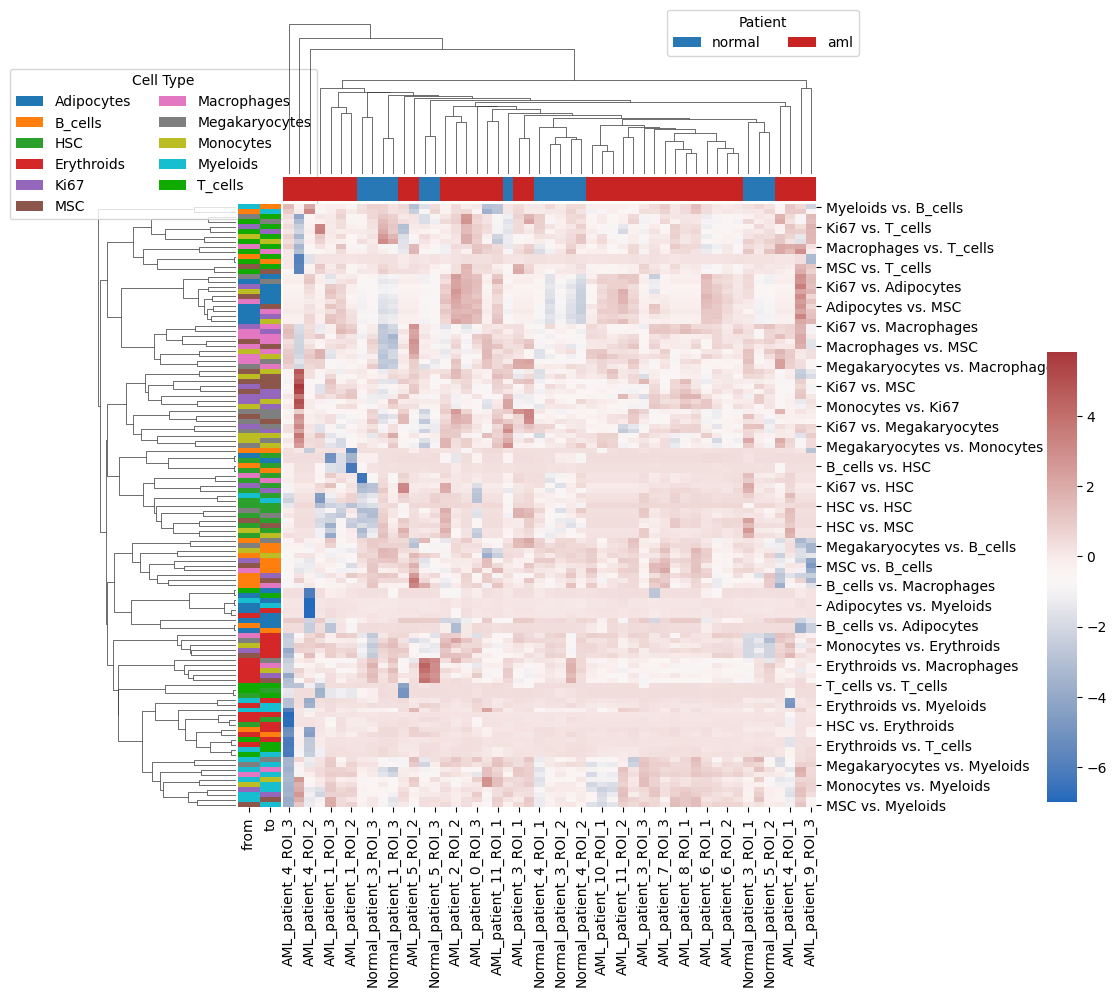

In [35]:
data_array=auc_r.T
data_array
data_array=data_array.fillna(0)
data_array = data_array.astype(np.float32)
da = pd.MultiIndex.from_frame(data_array.T)
used_columns = (da.get_level_values('label')
                          .astype(int))

data_array = data_array[0:121]
network_colors = []
for i in used_columns:
    if i==0:
        network_colors.append('#2878b5')
    else:
        network_colors.append('#c82423')
network_label = ["normal","aml"]
color_label = ['#2878b5','#c82423']

from_cell_color = pd.Series(from_cell_color,name="from")
to_cell_color = pd.Series(to_cell_color,name="to")
row_colors = pd.DataFrame(from_cell_color).join(pd.DataFrame(to_cell_color))
row_colors.index = data_array.index
print(row_colors)

g = sns.clustermap(data_array,z_score=0,cmap='vlag',col_colors=network_colors,row_colors=row_colors)
g.cax.set_position([.97, .2, .03, .45])
for label in network_label:
    index = network_label.index(label)
    g.ax_col_dendrogram.bar(0, 0, color=color_label[index], label=label, linewidth=0)
g.ax_col_dendrogram.legend(title='Patient', loc="center", ncol=5, bbox_to_anchor=(0.9, 0.9))

cell_type_label = ["Adipocytes", "B_cells", "HSC", "Erythroids", "Ki67", "MSC", 
                  "Macrophages", "Megakaryocytes", "Monocytes", "Myeloids", "T_cells"]
color_label = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf','#11aa00']
for label in cell_type_label:
    index = cell_type_label.index(label)
    g.ax_row_dendrogram.bar(0, 0, color=color_label[index], label=label, linewidth=0)
g.ax_row_dendrogram.legend(title='Cell Type', loc="center", ncol=2, bbox_to_anchor=(0.5, 1.1))

plt.show()

                           from       to
Ki67 vs. Ki67           #9467bd  #9467bd
Ki67 vs. Myeloids       #9467bd  #17becf
Ki67 vs. MSC            #9467bd  #8c564b
Ki67 vs. Monocytes      #9467bd  #bcbd22
Ki67 vs. Macrophages    #9467bd  #e377c2
...                         ...      ...
HSC vs. Megakaryocytes  #2ca02c  #7f7f7f
HSC vs. T_cells         #2ca02c  #11aa00
HSC vs. Adipocytes      #2ca02c  #1f77b4
HSC vs. Erythroids      #2ca02c  #d62728
HSC vs. HSC             #2ca02c  #2ca02c

[121 rows x 2 columns]


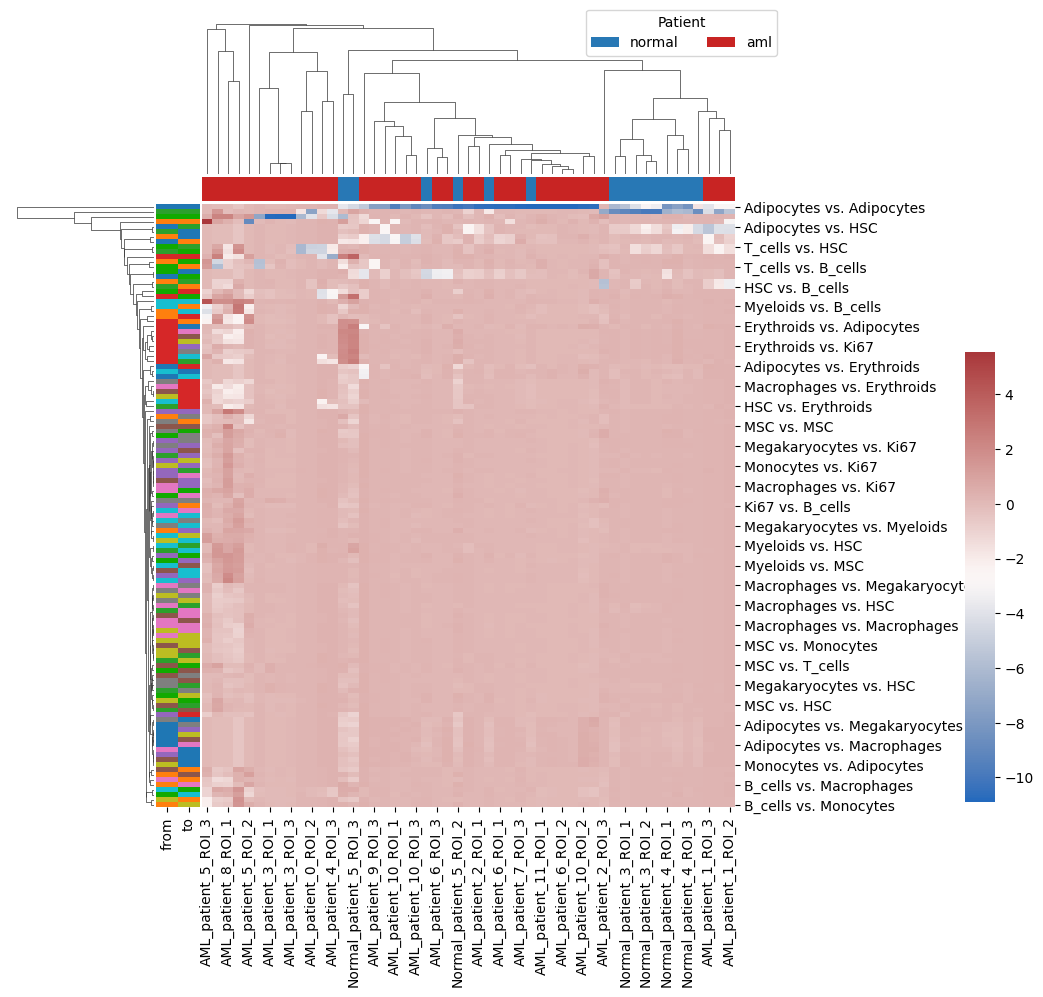

In [36]:
data_array=auc_r.T
data_array
data_array=data_array.fillna(0)
data_array = data_array.astype(np.float32)
da = pd.MultiIndex.from_frame(data_array.T)
used_columns = (da.get_level_values('label')
                          .astype(int))

data_array = data_array[0:121]
network_colors = []
for i in used_columns:
    if i==0:
        network_colors.append('#2878b5')
    else:
        network_colors.append('#c82423')
network_label = ["normal","aml"]
color_label = ['#2878b5','#c82423']

from_cell_color = pd.Series(from_cell_color,name="from")
to_cell_color = pd.Series(to_cell_color,name="to")
row_colors = pd.DataFrame(from_cell_color).join(pd.DataFrame(to_cell_color))
row_colors.index = data_array.index
print(row_colors)

g = sns.clustermap(data_array,z_score=1,cmap='vlag',col_colors=network_colors,row_colors=row_colors)
g.cax.set_position([.97, .2, .03, .45])
for label in network_label:
    index = network_label.index(label)
    g.ax_col_dendrogram.bar(0, 0, color=color_label[index], label=label, linewidth=0)
g.ax_col_dendrogram.legend(title='Patient', loc="center", ncol=5, bbox_to_anchor=(0.9, 0.9))

cell_type_label = ["Adipocytes", "B_cells", "HSC", "Erythroids", "Ki67", "MSC", 
                  "Macrophages", "Megakaryocytes", "Monocytes", "Myeloids", "T_cells"]
color_label = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf','#11aa00']
for label in cell_type_label:
    index = cell_type_label.index(label)
    g.ax_row_dendrogram.bar(0, 0, color=color_label[index], label=label, linewidth=0)
# g.ax_row_dendrogram.legend(title='Cell Type', loc="center", ncol=2, bbox_to_anchor=(0.5, 1.1))

plt.show()

In [4]:

data_array=auc_r.T
data_array
data_array=data_array.fillna(0)
data_array = data_array.astype(np.float32)
# Default plot
# g = sns.clustermap(data_array,z_score=1,cmap='RdBu')

# print(data_array.index)
da = pd.MultiIndex.from_frame(data_array.T)
used_columns = (da.get_level_values('label')
                          .astype(int))

print(used_columns)
network_colors = []
for i in used_columns:
    if i==0:
        network_colors.append('#c82423')
    else:
        network_colors.append('#2878b5')


g = sns.clustermap(data_array,z_score=0,cmap='BuRd',col_colors=network_colors)
# g.ax_row_dendrogram.legend(loc="center", ncol=2)
# Adjust the postion of the main colorbar for the heatmap
g.cax.set_position([.97, .2, .03, .45])
plt.show()

Int64Index([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
            1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            1, 1, 1, 1, 1, 1, 1],
           dtype='int64', name='label')


NameError: name 'sns' is not defined

In [ ]:
data_array=auc_r.T
data_array
data_array=data_array.fillna(0)
data_array = data_array.astype(np.float32)
# Default plot
g = sns.clustermap(data_array,z_score=0,cmap='RdBu')

In [ ]:
data_array_aml=auc_aml_r.T
data_array_aml=data_array_aml.fillna(0)
data_array_aml = data_array_aml.astype(np.float32)
data_array_normal=auc_normal_r.T
data_array_normal=data_array_normal.fillna(0)
data_array_normal = data_array_normal.astype(np.float32)
data_array = np.concatenate((data_array_aml,data_array_normal),axis=1)
# Default plot
sns.clustermap(data_array_aml,cmap="YlGnBu")
sns.clustermap(data_array_normal,cmap="hot")
# sns.clustermap(data_array,cmap="YlGnBu")
# Show the graph
plt.show()

In [ ]:
fig, (ax,ax2) = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=0.01)
sns_plot1 = sns.heatmap(data_array_normal,cmap="YlGnBu", ax=ax, cbar=False, yticklabels=False)
sns_plot1.tick_params(colors='#c82423')
sns_plot2 = sns.heatmap(data_array_aml,cmap="YlGnBu", ax=ax2, cbar=False)
sns_plot2.tick_params(colors='#2878b5')
fig.colorbar(ax.collections[0], ax=ax,location="left", use_gridspec=False, pad=0.2)
# fig.colorbar(ax2.collections[0], ax=ax,location="left", use_gridspec=False, pad=0.2)
ax2.yaxis.tick_right()
ax2.tick_params(rotation=0)
plt.show()

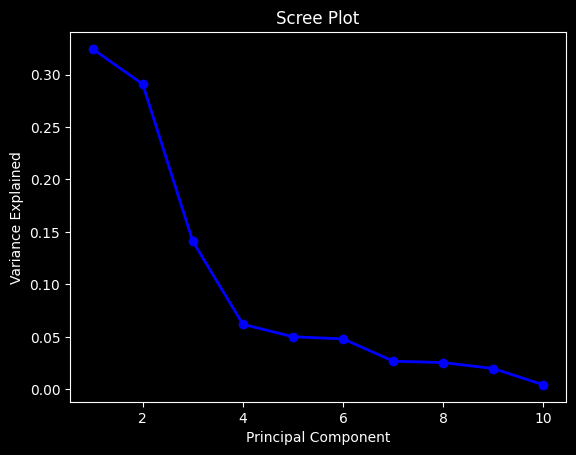

In [8]:
from mpl_toolkits import mplot3d
def scree_plot_aml_pca(auc_r):
    # plt.scatter(auc_r[component1], auc_r[component2])
    auc_r=auc_r.reset_index()
    auc_r=auc_r.fillna(0)
    auc_r = auc_r.drop('index', axis=1)
    # print(auc_r)
    pca_r = PCA(n_components=10)
    PC_values = np.arange(10) + 1
    # auc_r_select = auc_r
    pca_r_fit = pca_r.fit_transform(auc_r)
    plt.plot(PC_values, pca_r.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained')
    plt.show()

scree_plot_aml_pca(auc_r)

AnnData object with n_obs × n_vars = 4668 × 34
    obs: 'cell type'
    uns: 'cell type_colors'
    obsm: 'spatial'
[[242 137]
 [270 179]
 [  5 191]
 ...
 [200  80]
 [300 280]
 [130 230]]


/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:747: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if c is not None and c in adata.obs and is_categorical_dtype(adata.obs[c]):
/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/home/emmazhao/anaconda3/envs/emma/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/home/emm

OSError: [Errno 12] Cannot allocate memory

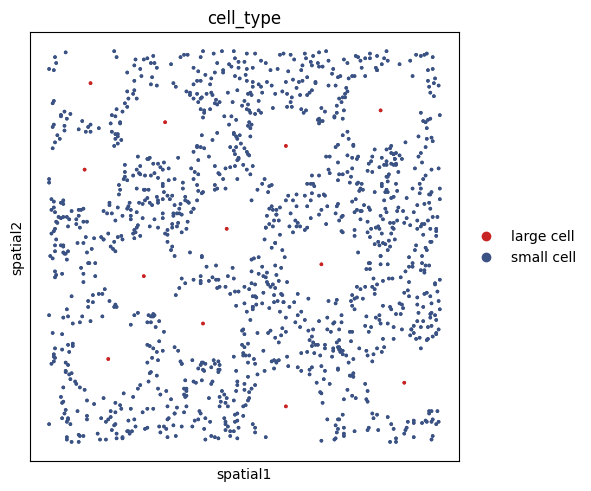

In [101]:
https://zenodo.org/record/5903179/files/Moldoveanu_2022_CyTOF_melanoma.tar.gz?download=1

In [45]:
print(random.sample(range(1, 10), 3))

[7, 3, 4]
